In [42]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import numpy as np

import requests
import time
from datasets import Dataset
from evaluate import load as load_metric

In [4]:
df = pd.read_csv("../../data/toxic.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


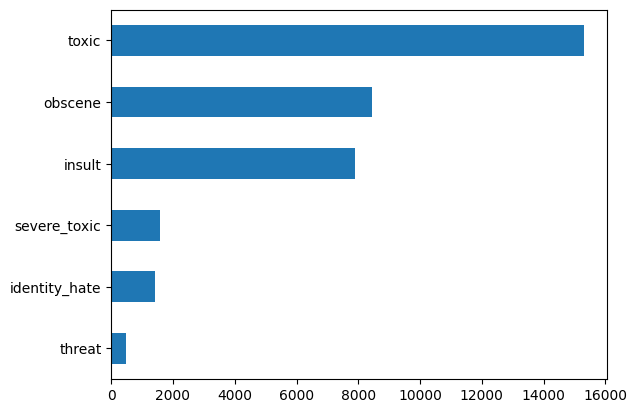

In [5]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

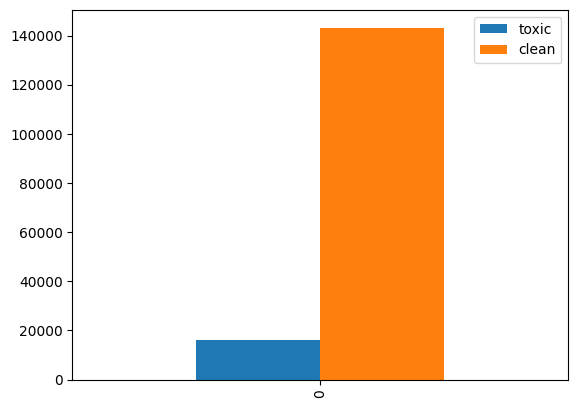

In [6]:
toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(toxic)], 
  clean=[len(clean)]
)).plot(kind='bar');

In [8]:
df = pd.concat([  # Take a hilariously small sample
  toxic.sample(50),
  clean.sample(50)
])

df['label'] = (df[LABEL_COLUMNS].sum(axis=1) > 0).astype(int)

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
155866,c502a2835e8986ff,Hahahahaha I wonder who was that silly!!!!!!!!...,1,0,0,0,1,0,1
94957,fddd0998403e66d8,"Moron \n\nKeep your nose out, imbecile.",1,0,1,0,1,0,1
72630,c253e034605ee865,is true. so i want to express that grant is ga...,1,0,0,0,0,1,1
101762,2091b186f10e4693,"""\n\nGreat, the Ukrainian nationalists again. ...",1,0,1,0,1,1,1
71894,c0831fe580352803,"You dosh bag, dont mess with me. My watch is w...",1,0,1,0,1,0,1


In [9]:
toxic_dataset = Dataset.from_pandas(df)

toxic_dataset = toxic_dataset.train_test_split(test_size=0.2)

In [10]:
bert_tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
sequence_classification_model.config.id2label = {0: 'Non-Toxic', 1: 'Toxic'}
sequence_classification_model.config.label2id = {'Non-Toxic': 0, 'Toxic': 1}

In [12]:
def preprocess(examples):
    return bert_tokenizer(examples['comment_text'], truncation=True)

In [13]:
toxic_dataset = toxic_dataset.map(preprocess)

Map: 100%|██████████| 20/20 [00:00<00:00, 1009.95 examples/s]


In [14]:
data_collator = DataCollatorWithPadding(bert_tokenizer)

In [15]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
api_key = 'HF_TOKEN_HERE'

# https://huggingface.co/profoz/distilbert-toxic-classifier
MODEL_IDENTIFIER = 'nt3000/distilbert-toxic-classifier-nt'

In [17]:
batch_size = 32
epochs = 1

training_args = TrainingArguments(
    output_dir='./toxicity/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./toxicity/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    eval_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=sequence_classification_model,  # set both model and tokenizer to push to hub
    tokenizer=bert_tokenizer,
    args=training_args,
    train_dataset=toxic_dataset['train'],
    eval_dataset=toxic_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

trainer.evaluate()

/var/folders/15/ntlyk3ln0p9by83mk1kl86dc0000gn/T/ipykernel_64179/3531244616.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.6967688798904419,
 'eval_model_preparation_time': 0.0005,
 'eval_accuracy': 0.4,
 'eval_runtime': 0.9621,
 'eval_samples_per_second': 20.787,
 'eval_steps_per_second': 1.039}

In [18]:
trainer.train()

/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.691300,0.678972,0.000500,0.650000


TrainOutput(global_step=3, training_loss=0.6913029352823893, metrics={'train_runtime': 24.6899, 'train_samples_per_second': 3.24, 'train_steps_per_second': 0.122, 'total_flos': 7041470159808.0, 'train_loss': 0.6913029352823893, 'epoch': 1.0})

In [19]:
trainer.save_model()

In [ ]:
trainer.model.push_to_hub(
    repo_id=MODEL_IDENTIFIER,
    use_auth_token=api_key
)

model.safetensors: 100%|██████████| 268M/268M [00:18<00:00, 14.2MB/s] 


CommitInfo(commit_url='https://huggingface.co/nt3000/distilbert-toxic-classifier-nt/commit/51b0a85479e88e8e7a867ddddcd97baaf67bee22', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='51b0a85479e88e8e7a867ddddcd97baaf67bee22', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nt3000/distilbert-toxic-classifier-nt', endpoint='https://huggingface.co', repo_type='model', repo_id='nt3000/distilbert-toxic-classifier-nt'), pr_revision=None, pr_num=None)

In [27]:
trainer.tokenizer.push_to_hub(
    repo_id=MODEL_IDENTIFIER,
    use_auth_token=api_key
)

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


CommitInfo(commit_url='https://huggingface.co/nt3000/distilbert-toxic-classifier-nt/commit/0d0ef7600f61361ba9579f17653f118abc080396', commit_message='Upload tokenizer', commit_description='', oid='0d0ef7600f61361ba9579f17653f118abc080396', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nt3000/distilbert-toxic-classifier-nt', endpoint='https://huggingface.co', repo_type='model', repo_id='nt3000/distilbert-toxic-classifier-nt'), pr_revision=None, pr_num=None)

## Example of online learning, continuing to train

In [28]:
# Load up our most recent version
auto_tokenizer = AutoTokenizer.from_pretrained(MODEL_IDENTIFIER)
auto_model = AutoModelForSequenceClassification.from_pretrained(MODEL_IDENTIFIER)

In [29]:
toxic_clf = pipeline(
    'text-classification',       
    model=auto_model,            
    tokenizer=auto_tokenizer,    
    use_fast=True,               # Use a fast tokenizer if possible
    return_all_scores=True       # Return probabilities for all classes
)

Device set to use mps:0
/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [30]:
toxic_clf('you are a dumb dumb')

[[{'label': 'Non-Toxic', 'score': 0.481783926486969},
  {'label': 'Toxic', 'score': 0.518216073513031}]]

In [31]:
# Example of online learning with some more data

df = pd.concat([
  toxic.sample(100),
  clean.sample(100)
])

df['label'] = (df[LABEL_COLUMNS].sum(axis=1) > 0).astype(int)

new_toxic_dataset = Dataset.from_pandas(df)

new_toxic_dataset = new_toxic_dataset.map(preprocess)

new_toxic_dataset = new_toxic_dataset.train_test_split(test_size=0.2)

Map: 100%|██████████| 200/200 [00:00<00:00, 1491.28 examples/s]


In [33]:
batch_size = 32
epochs = 1

training_args = TrainingArguments(
    output_dir='./toxicity/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir='./toxicity/logs',
    logging_strategy='epoch',
    save_strategy='epoch',
    eval_strategy='epoch',
    load_best_model_at_end=True
)

# Define the trainer
trainer = Trainer(
    model=auto_model,
    tokenizer=auto_tokenizer,
    args=training_args,
    train_dataset=new_toxic_dataset['train'],
    eval_dataset=new_toxic_dataset['test'],
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

trainer.evaluate()

/var/folders/15/ntlyk3ln0p9by83mk1kl86dc0000gn/T/ipykernel_64179/4029950115.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.674522876739502,
 'eval_model_preparation_time': 0.0008,
 'eval_accuracy': 0.675,
 'eval_runtime': 1.8125,
 'eval_samples_per_second': 22.069,
 'eval_steps_per_second': 1.103}

In [34]:
trainer.train()

/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.627800,0.579951,0.000800,0.725000


TrainOutput(global_step=5, training_loss=0.6278227806091309, metrics={'train_runtime': 77.0944, 'train_samples_per_second': 2.075, 'train_steps_per_second': 0.065, 'total_flos': 18065241491712.0, 'train_loss': 0.6278227806091309, 'epoch': 1.0})

In [35]:
trainer.save_model()

In [36]:
trainer.model.push_to_hub(
    repo_id=MODEL_IDENTIFIER,
    use_auth_token=api_key
)

trainer.tokenizer.push_to_hub(
    repo_id=MODEL_IDENTIFIER,
    use_auth_token=api_key
)

/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/transformers/utils/hub.py:907: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
model.safetensors: 100%|██████████| 268M/268M [00:13<00:00, 19.3MB/s] 
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


CommitInfo(commit_url='https://huggingface.co/nt3000/distilbert-toxic-classifier-nt/commit/5a23182c003f874b02d8a28e045bdb9ab4fd3b58', commit_message='Upload tokenizer', commit_description='', oid='5a23182c003f874b02d8a28e045bdb9ab4fd3b58', pr_url=None, repo_url=RepoUrl('https://huggingface.co/nt3000/distilbert-toxic-classifier-nt', endpoint='https://huggingface.co', repo_type='model', repo_id='nt3000/distilbert-toxic-classifier-nt'), pr_revision=None, pr_num=None)

In [37]:
toxic_clf = pipeline(
    'text-classification',       # the type of NLP task
    MODEL_IDENTIFIER,            # the handle of our newly pushed model
    use_fast=True,               # Use a fast tokenizer if possible
    return_all_scores=True       # Return probabilities for all classes
)

Device set to use mps:0
/Users/niketgirdhar/.pyenv/versions/3.12.3/lib/python3.12/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [38]:
toxic_clf('you are a dumb dumb')

[[{'label': 'Non-Toxic', 'score': 0.29073289036750793},
  {'label': 'Toxic', 'score': 0.7092670798301697}]]